## LLM

In [2]:
import torch as torch
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from transformer_kristianwold.transformer import Transformer, Inference
from transformer_kristianwold.optimization import train_step, forward_and_loss, group_decay_parameters, save_checkpoint, load_checkpoint
from transformer_kristianwold.utils import saver, loader
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)  
print("CUDA toolkit version PyTorch was built with:", torch.version.cuda)  
print("cuDNN version:", torch.backends.cudnn.version()) 
print("cuda available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

PyTorch version: 2.7.1+cu128
CUDA toolkit version PyTorch was built with: 12.8
cuDNN version: 90701
cuda available: True


## Load Data

In [3]:
tokenizer = loader("../../tokenizers/cnn_tokenizer3.pkl")

## Initialize Model

In [4]:
torch.manual_seed(42)

embed_dim = 64*18
ff_dim = 4*embed_dim
heads = 18
tf_blocks = 18

model = Transformer(
    embed_dim=embed_dim,
    ff_dim=ff_dim,
    heads=heads,
    tf_blocks=tf_blocks,
    vocab_size=tokenizer.vocab_size,
    max_seq_len=1024,
    dropout=0.1,
    start_token_id=tokenizer.token_to_idx["<s>"],
    use_weight_tying=True
).to(device)

optimizer_grouped_parameters = group_decay_parameters(
    model,
    weight_decay=0.1,
    no_decay=["bias", "LayerNorm.weight"],
    )

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5)
scaler = torch.amp.GradScaler("cuda")
loss_train_list = []
loss_test_list = []

num_epochs      = 1
steps_per_epoch = 1
warmup_steps    = 1000

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

[model, 
optimizer, 
scheduler, 
loss_train_list, 
loss_test_list] = load_checkpoint("../../models/checkpoint_transformer_5epoch.pth", 
                                  model, 
                                  optimizer, 
                                  scheduler, 
                                  loss_train_list, 
                                  loss_test_list)

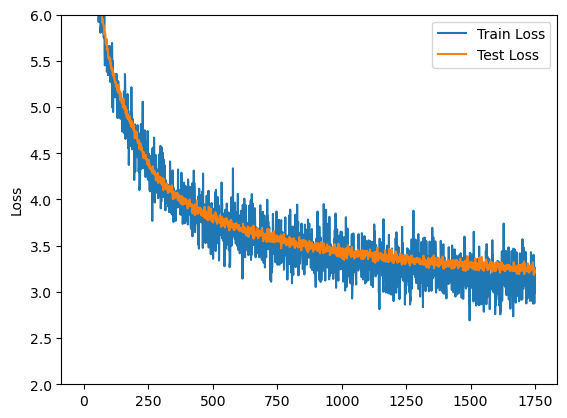

In [5]:
plt.plot(loss_train_list, label='Train Loss')
plt.plot(loss_test_list, label='Test Loss')
plt.ylim(2, 6)
plt.ylabel('Loss')
plt.legend()


In [10]:
def partition(text, sep):
    part = text.partition(sep)[2]
    part = part[:-4]
    return part

inference = Inference(model, tokenizer, context_length=1024, device=device)

In [7]:
highlight_list = loader("../../corpus/cnn_dailymail_highlight_test_cleaned.pkl")
article_list = loader("../../corpus/cnn_dailymail_article_test_cleaned.pkl")

## Ebola Infection Article

In [8]:
highlight = highlight_list[3]
article = article_list[3]

print(highlight)
print(article)

17 americans were exposed to the ebola virus while in sierra leone in march. another person was diagnosed with the disease and taken to hospital in maryland. national institutes of health says the patient is in fair condition after weeks of treatment.
(cnn)five americans who were monitored for three weeks at an omaha, nebraska, hospital after being exposed to ebola in west africa have been released, a nebraska medicine spokesman said in an email wednesday. one of the five had a heart-related issue on saturday and has been discharged but hasn't left the area, taylor wilson wrote. the others have already gone home. they were exposed to ebola in sierra leone in march, but none developed the deadly virus. they are clinicians for partners in health, a boston-based aid group. they all had contact with a colleague who was diagnosed with the disease and is being treated at the national institutes of health in bethesda, maryland. as of monday, that health care worker is in fair condition. the c

In [11]:
text = "<s><h>" + highlight + "<b>"

torch.manual_seed(42)
text_pred = inference.run(text, 
                             T = 0.75, 
                             k = 50)

article_pred = partition(text_pred, "<b>")
print(article_pred)

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

(cnn) -- four americans who were exposed to the deadly ebola virus in liberia, the health department said monday. one of the infected was in a tent at the liberian capital of san antonio, according to the centers for disease control and prevention. one of the men was treated at a medical center in bellevue, maryland, and is now in a stable condition, the health department said. the second man, who was treated at a medical center in maryland in late march, is in fair condition, the health department said. the other two is in stable condition. the other two are with suspected cases of ebola in the united states. the latest patient, who was treated at a hospital in monrovia, maryland, is in fair condition, the health department said. the two have been identified as 21-year-old sierra leonean thomas eric duncan. duncan is in a critical condition and is in a stable condition, the health department said. he is in a stable condition with three other patients who have died in the west african 

In [12]:
text = '<s><b>' + article_pred + '<h>'

torch.manual_seed(42)
text_pred = inference.run(text, 
                        T = 0.75, 
                        k = 50)

highlight_recovered = partition(text_pred, "<h>")
print(highlight_recovered)

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

a third patient is in stable condition, the health department says. five of the infected are in the liberian capital. one of the men was treated in a hospital in the united states. the outbreak has sickened more than 150 people in west africa.


## The Price is Right

In [19]:
highlight = highlight_list[9]
article = article_list[9]

print(highlight)
print(article)

bob barker returned to host "the price is right" on wednesday. barker, 91, had retired as host in 2007.
(cnn)for the first time in eight years, a tv legend returned to doing what he does best. contestants told to "come on down!" on the april 1 edition of "the price is right" encountered not host drew carey but another familiar face in charge of the proceedings. instead, there was bob barker, who hosted the tv game show for 35 years before stepping down in 2007. looking spry at 91, barker handled the first price-guessing game of the show, the classic "lucky seven," before turning hosting duties over to carey, who finished up. despite being away from the show for most of the past eight years, barker didn't seem to miss a beat.


In [20]:
text = "<s><h>" + highlight + "<b>"

torch.manual_seed(42)
text_pred = inference.run(text, 
                             T = 0.75, 
                             k = 50)

article_pred = partition(text_pred, "<b>")
print(article_pred)

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

(cnn) -- he's a 92-year-old former member of the house of representatives. in the final episode of "the price is right" on the show wednesday night, the 91-year-old former member of the house of representatives was pictured in a photograph with fellow members of the house of representatives. he did not want to be identified. barker, an 83-year-old former member of the house of representatives, was seen with a photo of his grandson, who was present and his wife, the woman she was meeting. the couple left the house in 2007, but it did not stop there. barker, an older man of 83, had retired as host in 2007, according to his publicist. he later made a name for himself as a guest host on the house committee. he had previously served as the house representative on the house committee. barker had retired as host on the house committee and had been married in 2007. he has two daughters from his previous marriages with three daughters.


In [21]:
text = '<s><b>' + article_pred + '<h>'

torch.manual_seed(42)
text_pred = inference.run(text, 
                        T = 0.75, 
                        k = 50)

highlight_recovered = partition(text_pred, "<h>")
print(highlight_recovered)

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

djerry barker leaves house of representatives in 2007. he had retired as host on house committee. he served as house representative on house committee. he has previously served as house representative on house committee.


## London Terror

In [22]:
highlight = highlight_list[10]
article = article_list[10]

print(highlight)
print(article)

london's metropolitan police say the man was arrested at luton airport after landing on a flight from istanbul. he's been charged with terror offenses allegedly committed since the start of november.
london (cnn)a 19-year-old man was charged wednesday with terror offenses after he was arrested as he returned to britain from turkey, london's metropolitan police said. yahya rashid, a uk national from northwest london, was detained at luton airport on tuesday after he arrived on a flight from istanbul, police said. he's been charged with engaging in conduct in preparation of acts of terrorism, and with engaging in conduct with the intention of assisting others to commit acts of terrorism. both charges relate to the period between november 1 and march 31. rashid is due to appear in westminster magistrates' court on wednesday, police said. cnn's lindsay isaac contributed to this report.


In [23]:
text = "<s><h>" + highlight + "<b>"

torch.manual_seed(42)
text_pred = inference.run(text, 
                             T = 0.75, 
                             k = 50)

article_pred = partition(text_pred, "<b>")
print(article_pred)

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

(cnn) -- a man who was arrested at luton airport on wednesday after landing on a flight from istanbul said he was arrested and questioned by an immigration officer. the man, who did not want to be named, was detained by immigration authorities. the man is charged with terrorism offenses, according to immigration and customs enforcement (fpf). he was booked on an unrelated charge. the man, originally from syria, was arrested wednesday at luton airport, where he boarded a flight from istanbul. he was charged with terror offenses, and the flight landed at luton international airport. he was arrested with suspected terrorism offenses, according to the airport. the latest charge is connected to the alleged plot in istanbul, the airport's website says.


In [24]:
text = '<s><b>' + article_pred + '<h>'

torch.manual_seed(42)
text_pred = inference.run(text, 
                        T = 0.75, 
                        k = 50)

highlight_recovered = partition(text_pred, "<h>")
print(highlight_recovered)

Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

a man on a flight from istanbul says he was arrested and questioned by immigration officers. he boarded the flight from istanbul to luton, authorities say. the man is charged with terrorism offenses, according to the airport's website.
